## EZKL for Electricity Demo 


## Define an LTSF-Linear Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Model(nn.Module):
    """
    Just one Linear layer
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x # [Batch, Output length, Channel]

Using cpu device


In [2]:
class Configs:
    def __init__(self):
      self.seq_len = 336
      self.pred_len = 96
      self.enc_in = 321
      self.individual = False
configs = Configs()
circuit = Model(configs)
circuit

Model(
  (Linear): Linear(in_features=336, out_features=96, bias=True)
)

## Train the Model Here

In [4]:
import pandas as pd
from datetime import datetime
df = pd.read_csv('../dataset/electricity.csv', index_col=0, parse_dates = True)
df

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,351.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,327.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,283.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0


<Axes: xlabel='date'>

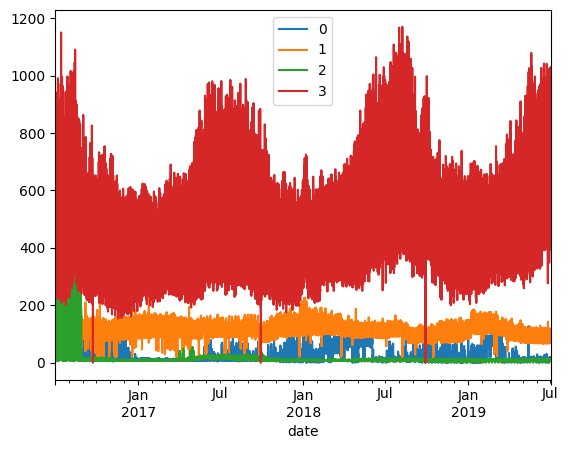

In [6]:
df[df.columns[:4]].plot()

In [7]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='../electricity.csv',
                 target='OT', scale=True, timeenc=0, freq='h', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.train_only = train_only

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        if self.features == 'S':
            cols.remove(self.target)
        cols.remove('date')
        # print(cols)
        num_train = int(len(df_raw) * (0.7 if not self.train_only else 1))
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            # print(self.scaler.mean_)
            # exit()
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
batch_size = 16

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

## ZK Inference

Model was trained and stored into checkpoint state 'checkpoint.pth'.
Now we need to export the onnx file with this state file.

In [3]:
# dummy_input = Variable(torch.randn(1, 3, 256, 256))
state_dict = torch.load('../checkpoints/checkpoint.pth')
circuit.load_state_dict(state_dict)
# torch.onnx.export(model, dummy_input, "moment-in-time.onnx")
print(circuit)

Model(
  (Linear): Linear(in_features=336, out_features=96, bias=True)
)


In [4]:
model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [5]:
import json
# After training, export to onnx (network.onnx) and create a data file (input.json)
x = 10*torch.rand(1,*[336, 96], requires_grad=True)

# Flips the neural net into inference mode
circuit.eval()

# Export the model
torch.onnx.export(circuit,               # model being run
                      x,                   # model input (or a tuple for multiple inputs)
                      model_path,            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump( data, open(data_path, 'w' ))

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [6]:
import ezkl

!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
assert res == True

In [7]:
res = ezkl.compile_model(model_path, compiled_model_path, settings_path)
assert res == True

In [11]:
!ezkl table -M network.onnx

[*] [0s, ezkl] - 
 |  
 |          ███████╗███████╗██╗  ██╗██╗
 |          ██╔════╝╚══███╔╝██║ ██╔╝██║
 |          █████╗    ███╔╝ █████╔╝ ██║
 |          ██╔══╝   ███╔╝  ██╔═██╗ ██║
 |          ███████╗███████╗██║  ██╗███████╗
 |          ╚══════╝╚══════╝╚═╝  ╚═╝╚══════╝
 |  
 |          -----------------------------------------------------------
 |          Easy Zero Knowledge for Neural Networks.
 |          -----------------------------------------------------------
 |  
 |          
[*] [0s, ezkl] - command: 
 |   {
 |    "command": {
 |      "Table": {
 |        "args": {
 |          "batch_size": 1,
 |          "bits": 16,
 |          "input_visibility": "Private",
 |          "logrows": 17,
 |          "output_visibility": "Public",
 |          "param_visibility": "Private",
 |          "scale": 7,
 |          "tolerance": {
 |            "scales": [
 |              1,
 |              1
 |            ],
 |            "val": 0.0
 |          }
 |        },
 |        "model": "net

In [8]:
# srs path
res = ezkl.get_srs(srs_path, settings_path)

In [9]:
# now generate the witness file 

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path, settings_path = settings_path)
assert os.path.isfile(witness_path)

In [10]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
        settings_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [12]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "evm",
        "single",
        settings_path,
    )

print(res)
assert os.path.isfile(proof_path)

{'instances': [[[8685059216286676104, 17055132664911953405, 2837402879488332698, 116049575279272326], [1865604365885106475, 1646489236851448653, 13778851042911942921, 2147331985690994546], [10282141587681049408, 680227977399193085, 9418395819538400641, 2561244520784542164], [3420741606167276385, 17986551702085942393, 4661913390892111615, 1986735109250368432], [12058150639037838039, 17069801705296992329, 7465438974925610505, 2878814093776206581], [7381856711771946919, 429036917624397183, 17012281127673022365, 3251803507597988222], [6399739590185315328, 17427336805135722162, 13442609240679692507, 3017137319636155801], [10834189140820486030, 4259213722244759794, 7329565058199841471, 863085545409135652], [15835953757847283995, 10636091325070561848, 4193964633321894710, 1695591937972118743], [14868840200418622684, 13617333182408587206, 2586489852975807341, 358492694263430393], [4545017430719590243, 1848169033962939051, 17467729001079831643, 978606549445257956], [15241961073595643979, 287858

In [13]:
# VERIFY IT

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")

verified
